In [1]:
# This line configures matplotlib to show figures embedded in the notebook.
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import folium
import geopandas as gpd

Source: [CDC: Chronic Disease Indicators](https://www.cdc.gov/cdi/index.html)

In [2]:
usecols = ['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 
       'GeoLocation', 'LocationID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1' ]

df = pd.read_csv("U.S._Chronic_Disease_Indicators__CDI_.csv", 
                 usecols=usecols, dtype={'DataValue': 'object'})

df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,US,United States,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,16.9,...,18.0,Overall,Overall,NaN,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,AL,Alabama,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,13.0,...,14.1,Overall,Overall,"(32.84057112200048, -86.63186076199969)",1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,AK,Alaska,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,18.2,...,20.6,Overall,Overall,"(64.84507995700051, -147.72205903599973)",2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,AZ,Arizona,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.6,...,16.9,Overall,Overall,"(34.865970280000454, -111.76381127699972)",4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,AR,Arkansas,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.0,...,17.2,Overall,Overall,"(34.74865012400045, -92.27449074299966)",5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


In [3]:
# Extract location-related attributes into a location table.
dfLocs = df[['LocationID', 'GeoLocation', 'LocationAbbr', 'LocationDesc']]\
    .set_index('LocationID').groupby('LocationID').first()

# Split GeoLocation string into Latitude and Longitude floats
geoLocs = dfLocs['GeoLocation'].str[1:-1].str.split(',', expand=True).astype('float')
geoLocs.columns=['Latitude', 'Longitude']
# Combine Lat/Long into Locations table, and drop unused column.
dfLocs = (pd.concat([dfLocs, geoLocs], axis=1)).drop('GeoLocation', axis=1)
dfLocs.head()

,LocationAbbr,LocationDesc,Latitude,Longitude
LocationID,,,,
1,AL,Alabama,32.840571,-86.631861
2,AK,Alaska,64.845080,-147.722059
4,AZ,Arizona,34.865970,-111.763811
5,AR,Arkansas,34.748650,-92.274491
6,CA,California,37.638640,-121.000000


In [4]:
gdfUSGeo = gpd.GeoDataFrame.from_file('us-states.json')
gdfUSGeo = gdfUSGeo.append(gpd.GeoDataFrame.from_file('us-territories.json'))
gdfUSGeo = gdfUSGeo.append(gpd.GeoDataFrame.from_file('us-mainland.json'))
gdfUSGeo.head()

,id,name,geometry
0,AL,Alabama,"POLYGON ((-87.359296 35.00118, -85.606675 34.9..."
1,AK,Alaska,"(POLYGON ((-131.602021 55.117982, -131.569159 ..."
2,AZ,Arizona,"POLYGON ((-109.042503 37.000263, -109.04798 31..."
3,AR,Arkansas,"POLYGON ((-94.473842 36.501861, -90.152536 36...."
4,CA,California,"POLYGON ((-123.233256 42.006186, -122.378853 4..."


In [5]:
dfGeoLocs = pd.merge(dfLocs.reset_index(), gdfUSGeo, 
                    left_on='LocationAbbr', right_on='id') \
            .drop(['id', 'name'], axis=1).set_index('LocationID')
dfGeoLocs.head()

,LocationAbbr,LocationDesc,Latitude,Longitude,geometry
LocationID,,,,,
1,AL,Alabama,32.840571,-86.631861,"POLYGON ((-87.359296 35.00118, -85.606675 34.9..."
2,AK,Alaska,64.845080,-147.722059,"(POLYGON ((-131.602021 55.117982, -131.569159 ..."
4,AZ,Arizona,34.865970,-111.763811,"POLYGON ((-109.042503 37.000263, -109.04798 31..."
5,AR,Arkansas,34.748650,-92.274491,"POLYGON ((-94.473842 36.501861, -90.152536 36...."
6,CA,California,37.638640,-121.000000,"POLYGON ((-123.233256 42.006186, -122.378853 4..."


In [6]:
# Extract topic attributes into a topic table.
dfTopics = df[['TopicID', 'Topic']].groupby('TopicID').first()
dfTopics.head()

,Topic
TopicID,
ALC,Alcohol
ART,Arthritis
AST,Asthma
CAN,Cancer
CKD,Chronic Kidney Disease


In [7]:
# Extract question attributes into a question table.
dfQuestions = df[['QuestionID', 'Question']].groupby('QuestionID').first()
dfQuestions.head()

,Question
QuestionID,
ALC10_0,Local authority to regulate alcohol outlet den...
ALC1_1,Alcohol use among youth
ALC1_2,Alcohol use before pregnancy
ALC2_1,Binge drinking prevalence among youth
ALC2_2,Binge drinking prevalence among adults aged >=...


In [8]:
# Extract Stratification attributes into a Stratification table.
dfStrats = df[['StratificationID1', 'Stratification1']].groupby('StratificationID1').first()
dfStrats

,Stratification1
StratificationID1,
AIAN,American Indian or Alaska Native
API,Asian or Pacific Islander
ASN,"Asian, non-Hispanic"
BLK,"Black, non-Hispanic"
GENF,Female
GENM,Male
HIS,Hispanic
MRC,"Multiracial, non-Hispanic"
OTH,"Other, non-Hispanic"


In [9]:
# Extract StratificationCategory attributes into a StratificationCategory table.
dfStratCats = df[['StratificationCategoryID1', 'StratificationCategory1']] \
    .groupby('StratificationCategoryID1').first()
dfStratCats

,StratificationCategory1
StratificationCategoryID1,
GENDER,Gender
OVERALL,Overall
RACE,Race/Ethnicity


In [10]:
# Extract DataValueType attributes into a DataValueType table.
dfDataValueTypes = df[['DataValueTypeID', 'DataValueType', 'DataValueUnit']]\
    .groupby('DataValueTypeID').first()
dfDataValueTypes

,DataValueType,DataValueUnit
DataValueTypeID,,
AgeAdjMean,Age-adjusted Mean,Number
AgeAdjPrev,Age-adjusted Prevalence,%
AgeAdjRate,Age-adjusted Rate,"cases per 10,000"
AgeSexRaceAdjRate,"Adjusted by age, sex, race and ethnicity","cases per 1,000,000"
AvgAnnAgeAdjRate,Average Annual Age-adjusted Rate,"per 100,000"
AvgAnnCrdRate,Average Annual Crude Rate,"per 100,000"
AvgAnnNmbr,Average Annual Number,NaN
CommHstLiab,Commercial host (dram shop) liability status f...,NaN
CrdPrev,Crude Prevalence,%


In [11]:
dfData = df.drop(['GeoLocation', 'LocationAbbr', 'LocationDesc', 'Topic', 'Question', 
    'Stratification1', 'StratificationCategory1', 'DataValueType', 'DataValueUnit'], axis=1)
dfData.head()

,YearStart,YearEnd,DataSource,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,BRFSS,16.9,16.9,*,50 States + DC: US Median,16.0,18.0,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,BRFSS,13.0,13.0,NaN,NaN,11.9,14.1,1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,BRFSS,18.2,18.2,NaN,NaN,16.0,20.6,2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,BRFSS,15.6,15.6,NaN,NaN,14.3,16.9,4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,BRFSS,15.0,15.0,NaN,NaN,13.0,17.2,5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


In [12]:
def getIndicator(qid, strat, valuetype, additional={}):
    # Drill into indicator 
    dfQ = dfData[df['QuestionID'] == qid]
    # Strip out NaN data values
    dfQ = dfQ[(dfQ['DataValueAlt'].notnull()) &
                    (dfQ['StratificationCategoryID1'] == strat) &
                    #(dfQ['LocationID'] == 1) &
                    #(dfQ['YearStart'] == 2016) &
                    (dfQ['DataValueTypeID'] == valuetype)]
    for k, v in additional.items():
        dfQ = dfQ[dfQ[k] == v]
    dfQ = dfQ.groupby('LocationID').mean()
    dfQ = pd.merge(dfQ, dfLocs, left_index=True, right_index=True)
    # Strip out U.S. general location (keep only state/territory data)
    #df11_3 = df11_3[df11_3['Latitude'].notnull()]
    dfQ = dfQ[dfQ['LocationAbbr'] != 'US']
    return dfQ

In [13]:
def mapDataFrame(df, cl='YlGn'):
    mapIndicator = folium.Map([43, -100], zoom_start=4)
    
    mapIndicator.choropleth(
        #geo_data=gdfUSGeo,
        #geo_path='us-states.json',
        geo_data=open('us-states.json').read(),
        data=df,
        columns=['LocationAbbr', 'DataValueAlt'],
        key_on='feature.id',
        fill_color=cl,
    )
    return mapIndicator

def mapIndicator(qid, strat, valuetype, additional={}, cl='YlGn'):
    dfIndicator = getIndicator(qid, strat, valuetype, additional=additional)
    mapIndicator = mapDataFrame(dfIndicator, cl=cl)
    return mapIndicator

In [16]:
pivot_nonstrat = ['TopicID', 'YearStart', 'YearEnd', 'LocationID']
pivot_index = pivot_nonstrat + ['StratificationID1']

In [17]:
dfRace = dfData[(dfData["TopicID"] == 'DIA') &
#                (dfData['DataValueTypeID'] == 'AgeAdjPrev') &
                (dfData['DataValueTypeID'] == 'CrdPrev') &
                 dfData['DataValueAlt'].notnull() &
#                (dfData['LocationID'] == 1) &
#                (dfData['YearStart'] == 2016) &
                (dfData['StratificationCategoryID1'] == 'RACE')]

dfRace = pd.pivot_table(dfRace, index = pivot_index, columns = 'QuestionID',  values = 'DataValueAlt').reset_index()
dfRaceIndicators = dfRace.drop(pivot_nonstrat, axis=1)
dfRaceIndicators.head()

QuestionID,StratificationID1,DIA10_0,DIA11_1,DIA11_2,DIA11_3,DIA12_1,DIA12_2,DIA13_1,DIA13_2,DIA2_1,DIA2_2,DIA5_0,DIA6_0,DIA7_0,DIA8_0
0,BLK,58.8,64.4,83.4,25.3,41.3,54.8,48.2,64.9,13.6,9.2,80.7,68.4,68.2,NaN
1,WHT,55.4,76.6,74.9,30.8,44.4,71.7,44.9,83.0,11.3,8.6,61.0,73.2,66.7,NaN
2,OTH,45.1,59.2,84.5,NaN,NaN,NaN,NaN,NaN,8.4,NaN,81.5,NaN,84.3,NaN
3,WHT,67.4,62.8,74.2,31.7,29.2,51.0,57.5,82.9,6.9,8.1,75.8,62.8,62.1,NaN
4,BLK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.9,NaN,NaN,NaN,NaN,NaN


In [141]:
dfDia = dfData[dfData["TopicID"] == 'DIA']
types = dfDia['DataValueTypeID'].value_counts().index
for t in types:
    n = dfDia[dfDia['DataValueTypeID'] == t]['DataValueAlt'].notnull()
    print("%s: %0.1f%%; %d / %d" % (t, 100 * n.sum() / n.count(), n.sum(), n.count()))

CrdPrev: 53.6%; 17152 / 32012
AgeAdjPrev: 54.5%; 16352 / 30007
AgeAdjRate: 58.3%; 3396 / 5830
CrdRate: 58.3%; 3396 / 5830
Nmbr: 58.3%; 3396 / 5830
Prev: 100.0%; 52 / 52


In [142]:
qs = dfDia['QuestionID'].value_counts().index
for q in qs:
    n = dfDia[dfDia['QuestionID'] == q]['DataValueAlt'].notnull()
    print("%s: %0.1f%%; %d / %d" % (q, 100 * n.sum() / n.count(), n.sum(), n.count()))

DIA1_1: 81.5%; 4998 / 6135
DIA1_2: 36.1%; 2214 / 6135
DIA13_1: 58.5%; 3052 / 5220
DIA12_2: 56.8%; 2965 / 5220
DIA13_2: 56.2%; 2934 / 5220
DIA2_1: 81.3%; 4242 / 5220
DIA12_1: 59.5%; 3106 / 5220
DIA11_3: 60.1%; 3136 / 5220
DIA7_0: 39.3%; 2050 / 5216
DIA10_0: 39.3%; 2052 / 5216
DIA6_0: 38.8%; 2024 / 5216
DIA5_0: 39.2%; 2045 / 5216
DIA9_0: 64.1%; 1674 / 2610
DIA11_2: 65.3%; 1704 / 2610
DIA8_0: 65.1%; 1699 / 2610
DIA11_1: 64.5%; 1683 / 2610
DIA4_0: 49.9%; 1302 / 2610
DIA2_2: 40.5%; 789 / 1950
DIA3_1: 41.8%; 23 / 55
DIA3_2: 100.0%; 52 / 52


In [270]:
def notNullHeatMap(df, cmap="Blues", figsize=(12,6)):
    usable = pd.pivot_table(df, index='QuestionID', columns='DataValueTypeID', values='DataValueAlt', 
                   aggfunc=lambda x: sum(x.notnull()))
    # Strip off 'DIA' prefix
    usable.index = usable.index.str[3:]
    fig, ax = plt.subplots(figsize=figsize)   
    _ = sns.heatmap(usable, cmap=cmap, annot=True, fmt='g', ax=ax)

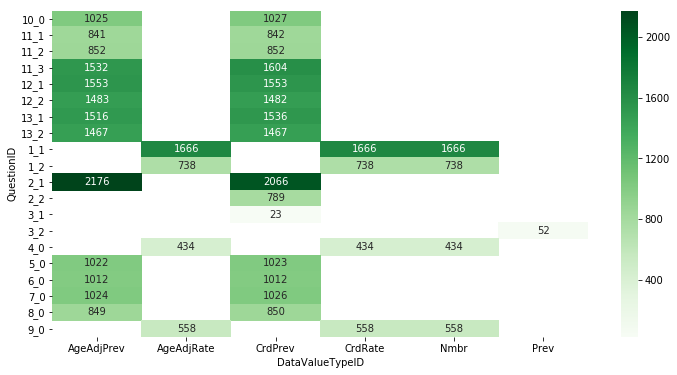

In [271]:
notNullHeatMap(dfDia, "Greens")

In [272]:
dfDia[dfDia['QuestionID'] == 'DIA3_1']['DatavalueFootnote'].value_counts()

No data available    32
Name: DatavalueFootnote, dtype: int64

In [273]:
len(dfDia[(dfDia['QuestionID'] == 'DIA3_2') & dfDia['DataValueAlt'].notnull()]['LocationID'].unique())

52

In [274]:
dfDia[dfDia['QuestionID'] == 'DIA1_1']['DatavalueFootnote'].value_counts()

                                                          4983
Data not shown because of too few respondents or cases    1137
Name: DatavalueFootnote, dtype: int64

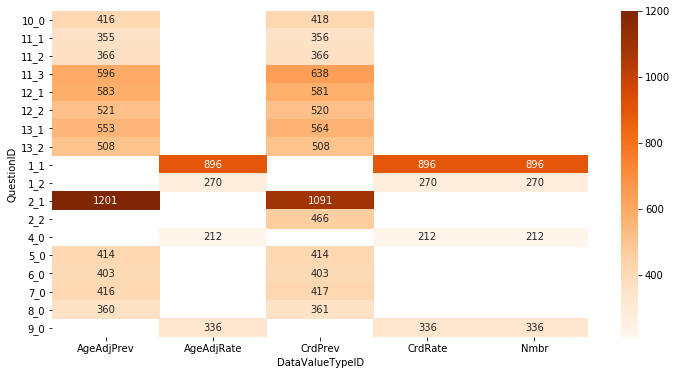

In [275]:
notNullHeatMap(dfDia[dfDia['StratificationCategoryID1'] == 'RACE'], "Oranges")

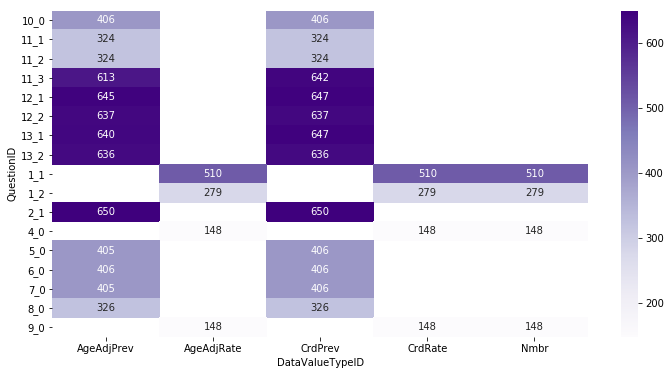

In [276]:
notNullHeatMap(dfDia[dfDia['StratificationCategoryID1'] == 'GENDER'], "Purples")

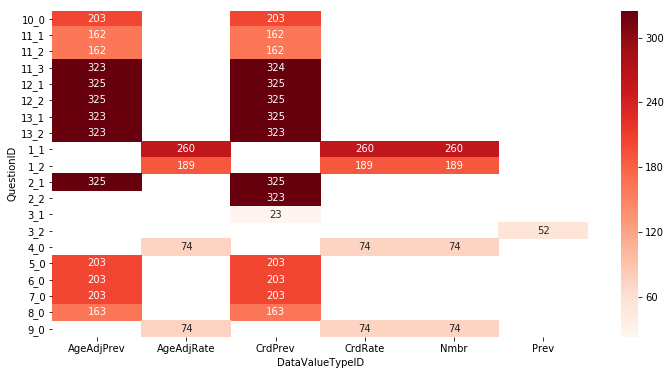

In [277]:
notNullHeatMap(dfDia[dfDia['StratificationCategoryID1'] == 'OVERALL'], "Reds")

In [278]:
dfDia[(dfDia['QuestionID'] == 'DIA4_0') & dfDia['DataValueAlt'].notnull() &
      (dfDia['LocationID'] == 8) & (dfDia['StratificationCategoryID1'] == 'OVERALL')].head()

,YearStart,YearEnd,DataSource,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
133199,2013,2013,State Inpatient Data,1.76,1.76,,,1.65,1.86,8,DIA,DIA4_0,AgeAdjRate,OVERALL,OVR
133398,2013,2013,State Inpatient Data,1.87,1.87,,,1.76,1.99,8,DIA,DIA4_0,CrdRate,OVERALL,OVR
133599,2013,2013,State Inpatient Data,988,988.00,,,NaN,NaN,8,DIA,DIA4_0,Nmbr,OVERALL,OVR
257444,2010,2010,State Inpatient Data,1.74,1.74,,,1.63,1.86,8,DIA,DIA4_0,AgeAdjRate,OVERALL,OVR
257685,2010,2010,State Inpatient Data,1.76,1.76,,,1.64,1.87,8,DIA,DIA4_0,CrdRate,OVERALL,OVR


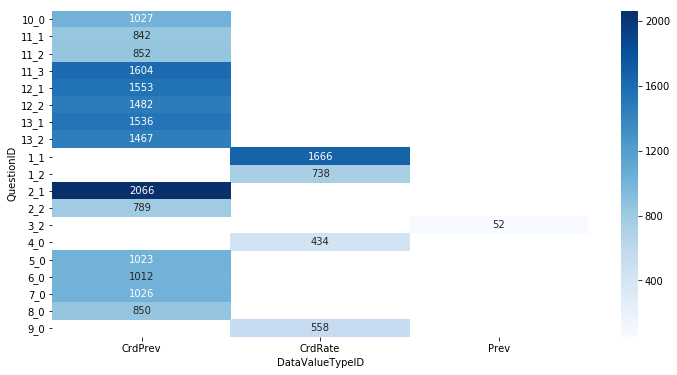

In [290]:
dfOneType = dfDia[(dfDia['QuestionID'] != 'DIA3_1') &
                   dfDia['DataValueTypeID'].isin(['CrdPrev', 'CrdRate', 'Prev'])]
notNullHeatMap(dfOneType)

In [338]:
def notNullBarChart(df, cmap="Blues", figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.barh(df.columns, df.notnull().sum())

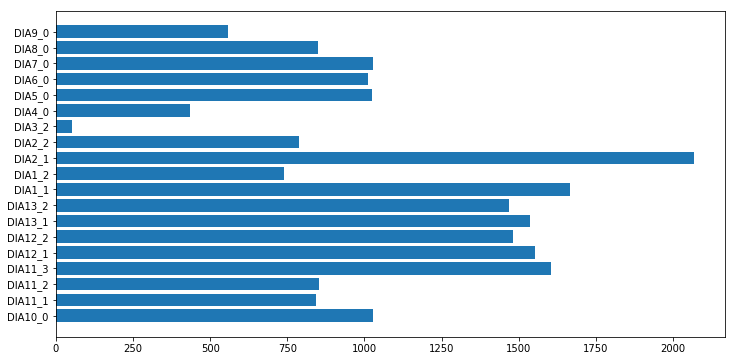

In [339]:
sparsePivot = pd.pivot_table(dfOneType, index=['TopicID', 'YearStart', 'YearEnd', 'LocationID', 'StratificationID1'], 
                             columns='QuestionID', values='DataValueAlt')

notNullBarChart(sparsePivot)

In [340]:
sparsePivot

QuestionID                                              DIA10_0  DIA11_1  \
TopicID YearStart YearEnd LocationID StratificationID1                     
DIA     2010      2010    1          AIAN                   NaN      NaN   
                                     API                    NaN      NaN   
                                     BLK                    NaN      NaN   
                                     GENF                   NaN      NaN   
                                     GENM                   NaN      NaN   
                                     HIS                    NaN      NaN   
                                     OVR                    NaN      NaN   
                                     WHT                    NaN      NaN   
                          2          AIAN                   NaN      NaN   
                                     API                    NaN      NaN   
                                     BLK                    NaN      NaN   
                                     GENF                   NaN      NaN   
                                     GENM                   NaN      NaN   
                                     HIS                    NaN      NaN   
                                     OVR                    NaN      NaN   
                                     WHT                    NaN      NaN   
                          4          AIAN                   NaN      NaN   
                                     API                    NaN      NaN   
                                     BLK                    NaN      NaN   
                                     GENF                   NaN      NaN   
                                     GENM                   NaN      NaN   
                                     HIS                    NaN      NaN   
                                     OVR                    NaN      NaN   
                                     WHT                    NaN      NaN   
                          5          AIAN                   NaN      NaN   
                                     API                    NaN      NaN   
                                     BLK                    NaN      NaN   
                                     GENF                   NaN      NaN   
                                     GENM                   NaN      NaN   
                                     HIS                    NaN      NaN   
...                                                         ...      ...   
        2016      2016    56         OTH                    NaN      NaN   
                                     OVR                   56.0      NaN   
                                     WHT                   58.4      NaN   
                          59         GENF                   NaN      NaN   
                                     GENM                   NaN      NaN   
                                     OVR                    NaN      NaN   
                          66         BLK                    NaN      NaN   
                                     GENF                  36.4      NaN   
                                     GENM                  44.2      NaN   
                                     HIS                    NaN      NaN   
                                     MRC                    NaN      NaN   
                                     OTH                   33.5      NaN   
                                     OVR                   40.0      NaN   
                                     WHT                    NaN      NaN   
                          72         BLK                    NaN      NaN   
                                     GENF                  22.5      NaN   
                                     GENM                  27.1      NaN   
                                     HIS                   24.5      NaN   
                                     MRC                    NaN      NaN   
                                     OTH        